# Testing Graphs on Star Clusters

Using LightGraphs we test some graphs decomposition of the stellar cluster data

In [1]:
using PyCall
using Statistics , MultivariateStats
using Printf, Glob
using ImageFiltering
using Query, DataFrames, LightGraphs
using GraphPlot

import PyPlot , CSV , Distances
import Base.copy

sns= pyimport("seaborn")

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

#Constants
const G= 4.30091e-3   #[solar mass][pc][km/s]

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc2"

cd(wdir)

In [2]:
g = SimpleGraph()
add_vertex!(g)
add_vertices!(g,10)
add_edge!(g, 1 ,2)
add_edge!(g, 1 ,5)
add_edge!(g, 3 ,9)
add_edge!(g, 4,8)
add_edge!(g, 10,4)
add_edge!(g, 10,4)
add_edge!(g, 8,2)
add_edge!(g, 8,3)
add_edge!(g, 2,3)
nodelabel = collect(1:nv(g))
println(nodelabel)

gplot(g, nodelabel=nodelabel)

println(maximal_cliques(g))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Array{Int64,1}[[2, 3, 8], [2, 1], [11], [7], [9, 3], [10, 4], [6], [4, 8], [5, 1]]


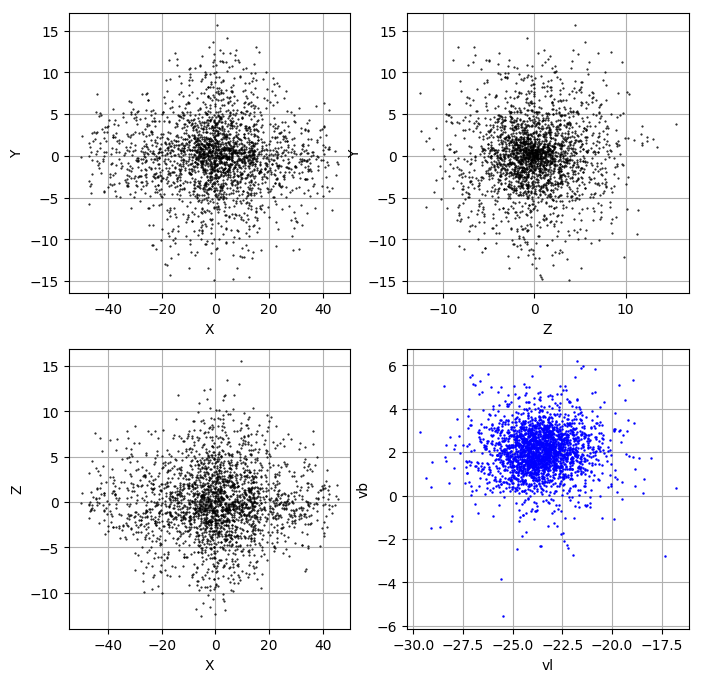

In [3]:
# ocname= "NGC 2168-4.9deg-oc-mass.csv"
ocname= "NGC 2516-3.5deg-oc-mass.csv"
#ocname= "NGC 1980-1.2deg-oc-mass.csv"
#ocname= "Collinder 419-1.0deg-oc-mass.csv"

oc= CSV.read("$ocdir/$ocname", delim= ";")

## plot the cluster
## OC recentered
oc.X= oc.X .- mean(oc.X)
oc.Y= oc.Y .- mean(oc.Y)
oc.Z= oc.Z .- mean(oc.Z)


fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Z")
ax= PyPlot.subplot(224)
PyPlot.grid("on")
PyPlot.plot(oc.vl, oc.vb,"b.",markersize= 1.5 )
PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
PyPlot.show()

In [25]:
## functions

function create_graph_XV(oc, dmax, vmax)
    g = SimpleGraph()
    ndata= length(oc.ra)
    add_vertices!(g,ndata)
    
    A= Array{Float64}(undef,2,ndata)
    B= Array{Float64}(undef,2,ndata)
    for i in 1:ndata
        A[:,i]= [oc.Y[i] oc.Z[i]]
        B[:,i]= [oc.vl[i] oc.vb[i]]
    end

    d= Distances.Euclidean()
    Ax= Distances.pairwise(d, A, A, dims=2)
    Av=  Distances.pairwise(d, B, B, dims=2)
     
    for i in 1:ndata
        for j in 1:i-1
            if Ax[i,j] <= dmax && Av[i,j] <= vmax && i != j
                add_edge!(g, i,j)
            end
        end
    end
    
    return(g)
end


#### v: vertices
function plot_vert(v)
    fig= PyPlot.figure(figsize=(8,8))

    ax= PyPlot.subplot(221)
    PyPlot.grid("on")
    PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
    PyPlot.plot(oc.X[v], oc.Y[v],"r*",markersize=2)
    PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
    ax= PyPlot.subplot(222)
    PyPlot.grid("on")
    PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
    PyPlot.plot(oc.Z[v], oc.Y[v],"r*", markersize=2)
    PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
    ax= PyPlot.subplot(223)
    PyPlot.grid("on")
    PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
    PyPlot.plot(oc.X[v], oc.Z[v],"r*",markersize=2)
    PyPlot.xlabel("X") ; PyPlot.ylabel("Z")
    ax= PyPlot.subplot(224)
    PyPlot.grid("on")
    PyPlot.plot(oc.vl, oc.vb,"b.",markersize= 1. )
    PyPlot.plot(oc.vl[v], oc.vb[v],"rD",markersize= 2 )
    PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
    PyPlot.show()
    
end

plot_vert (generic function with 1 method)

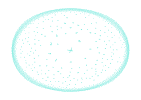

In [30]:
### MAIN
g= create_graph_XV(oc,0.4,0.4)
gplot(g)


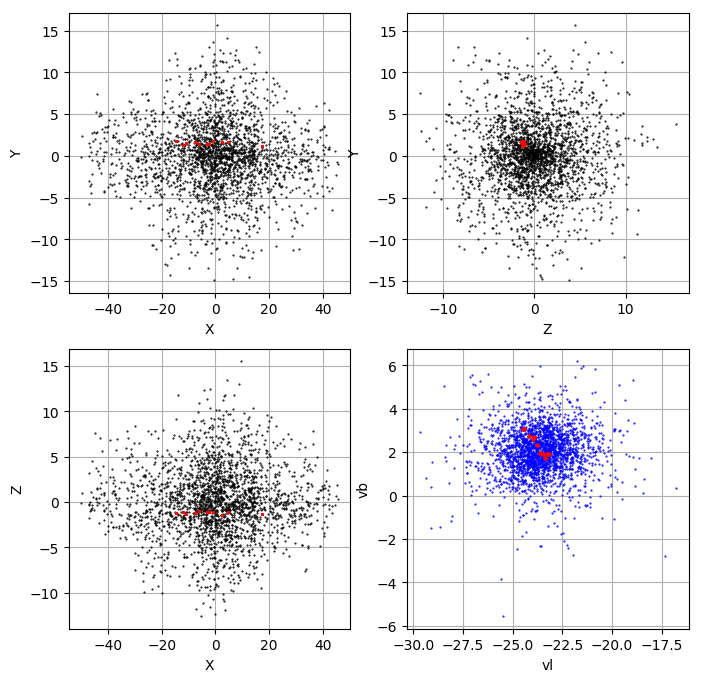

[290, 308, 309, 310, 311, 334, 336, 353, 404, 517, 545]
[9]


Dict{Int64,Int64} with 6 entries:
  0 => 1953
  4 => 5
  2 => 83
  3 => 15
  5 => 2
  1 => 315

In [31]:
# print(maximal_cliques(g))

for cl in maximal_cliques(g)
    if length(cl) > 2
        # println(cl)
    end
end

t= connected_components(g)
tmax=[]
for co in t
    if length(co) > length(tmax)
        tmax=co
    end
end
println(tmax)

dd= degree(g)

println(t[9])
plot_vert(tmax)

# println(degree(g))
dh= degree_histogram(g)
# println(maximal_cliques(g))

# println(degree_centrality(g,normalize=true))



In [32]:
nbin= 5
clmat= zeros(Float64, nbin, nbin)

dx= 1.0 / nbin ; dy= 1.0 / nbin
for i in 1:nbin
    for j in 1:nbin
        dm= dx*i
        dv= dy*j
        
        gi= create_graph_XV(oc,dm,dv)
        cli= maximal_cliques(gi)
        
        ccon= connected_components(gi)
        ncli= 0 ; nccon= 0
        for cl in cli
            if length(cl) > 2  ncli +=1 end
        end 
        for con in ccon
            if length(con) > 2  nccon +=1 end
        end
        
        if nccon==0 nccon=1 end
        clmat[i,j]= ncli/nccon
    end
end

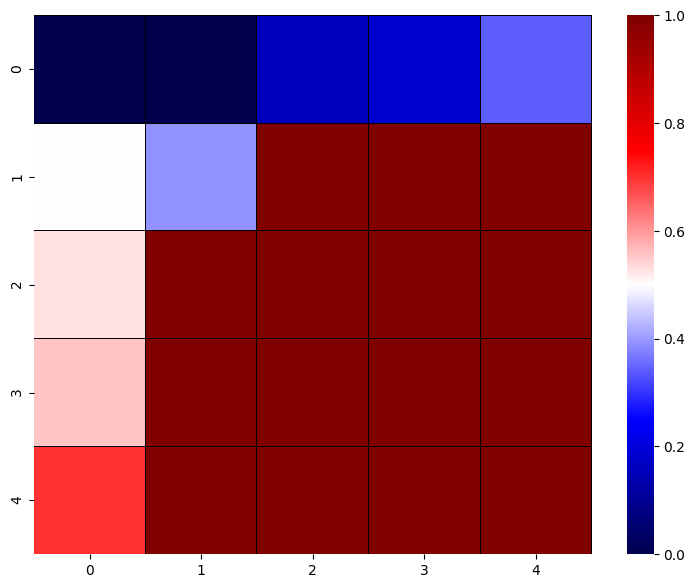

In [33]:
fig= PyPlot.figure(figsize=(9,7))
heat_map = sns.heatmap(clmat, vmin=0, vmax=1, cmap= "seismic",linewidths=0.1, 
    linecolor="black")
PyPlot.show()
